In [1]:
import sys
sys.path.append('..')
import datetime
import time
from collections import Counter
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from kneed import KneeLocator
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, log_loss, roc_auc_score
import json
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
def cross_entropy_loss(model, x_test, y_test):
    
    probs = model.predict_proba(x_test)
    
    predicted_probs = []
    for i, true_label in enumerate(y_test):
        idx_arr = np.where(model.classes_ == true_label)[0]
        if len(idx_arr) == 0:
            predicted_probs.append(log_loss(y_true = [1,0], y_pred=[0,1])+1)
        else:
            col_index = idx_arr[0]
            true_label_one_hot = np.zeros_like(probs[i])
            true_label_one_hot[idx_arr] = 1
            predicted_probs.append(log_loss(y_true = true_label_one_hot, y_pred = probs[i]))
            
    return np.array(predicted_probs)

In [3]:
def normal_loss(model, x_test, y_test):
    
    probs = model.predict_proba(x_test)

    predicted_probs = []
    for i, true_label in enumerate(y_test):
        idx_arr = np.where(model.classes_ == true_label)[0]
        if len(idx_arr) == 0:
            predicted_probs.append(1.1)
        else:
            col_index = idx_arr[0]
            
            true_label_one_hot = np.zeros_like(probs[i])
            true_label_one_hot[idx_arr] = 1
            predicted_probs.append(1-probs[i][col_index])
            
    return np.array(predicted_probs)

In [4]:
def safe_transform_target(encoder, targets, unknown_value=-1):
    classes = set(encoder.classes_)
    transformed = []
    for t in targets:
        if t in classes:
            transformed.append(encoder.transform([t])[0])
        else:
            transformed.append(unknown_value)
    return np.array(transformed)

In [5]:
def get_clean_loss(normal_loss_value, cross_entropy_loss_value):
    normal_loss_dist = []
    cross_loss_dist = []
    for pos, prediction in  enumerate(normal_loss_value):
        if prediction != 1:
            cross_loss_dist.append(cross_entropy_loss_value[pos])
            normal_loss_dist.append(prediction)

    return normal_loss_dist, cross_loss_dist

In [6]:
def cleaning_cls_result(classification_result):
    
    for i in classification_result.keys():
        print(i, classification_result[i].keys())

        if '1' not in classification_result[i].keys():
            classification_result[i]['1'] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0.0}
    return classification_result

In [7]:
def sample_with_min_anomalies(gt_labels, num_samples=10, min_anomalies=3, random_state=None):
    """
    Randomly sample `num_samples` indices from gt_labels (0/1 array),
    ensuring at least `min_anomalies` true-anomaly (1) indices are included.

    Parameters
    ----------
    gt_labels : array-like, shape (n_samples,)
        Ground-truth labels (0 = normal, 1 = anomaly).
    num_samples : int, default=10
        Total number of indices to sample.
    min_anomalies : int, default=3
        Minimum number of anomaly indices to include.
    random_state : int or None
        Seed for reproducibility.

    Returns
    -------
    selected_indices : ndarray, shape (<= num_samples,)
        Shuffled indices, containing at least `min_anomalies` anomalies
        (or as many as available if fewer exist).
    """
    gt_labels = np.asarray(gt_labels)
    if random_state is not None:
        np.random.seed(random_state)

    # locate anomaly vs normal indices
    anomaly_idx = np.where(gt_labels == 1)[0]
    normal_idx  = np.where(gt_labels == 0)[0]

    # determine how many anomalies we can pick
    n_anom = min(len(anomaly_idx), min_anomalies)
    # pick anomalies without replacement
    picked_anom = np.random.choice(anomaly_idx, n_anom, replace=False) if n_anom > 0 else np.array([], dtype=int)

    # fill the rest from normals
    n_normal = num_samples - n_anom
    n_normal = min(n_normal, len(normal_idx))
    picked_norm = np.random.choice(normal_idx, n_normal, replace=False) if n_normal > 0 else np.array([], dtype=int)

    # combine and shuffle
    selected = np.concatenate([picked_anom, picked_norm])
    np.random.shuffle(selected)

    return selected

In [19]:
# ----------------------------
# Step 1: Read and Process the Data
# ----------------------------
dataset = '0.099_noise.csv'
df = pd.read_csv("../data/%s" % (dataset))
df = df.sort_values(by='Timestamp')
# Process the 'noise' column:
# - If NaN, assume Normal (0).
# - Otherwise, treat True/1/'True' as anomaly (1); everything else as Normal (0).
df['noise'] = df['noise'].fillna(0).apply(lambda x: 1 if (x == True or x == 1 or x == 'True' or x=='true') else 0)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print(dataset)
# Calculate the cutoff time (e.g., the median of all timestamps)
cutoff_time = df['Timestamp'].median()

anomaly_f1_list = []
anomaly_support_list = []
prefix_range = range(6, 10)

0.099_noise.csv


In [20]:
prefix_normal_loss = {}

In [21]:
training_size = 0.8
print('Training window size: %s' % (training_size))
loss_prefix_dict =dict()

# for anomaly_thr_method in ['min', 'avg', 'median', 'max']:
classification_result = dict()    
for prefix in prefix_range:    
    # Extract per case:
    # - The first (prefix-1) events (activities) as features.
    # - The prefix-th event's activity as the target.
    # - The prefix-th event's noise flag as the ground truth anomaly.
    case_features = []
    case_targets = []
    ground_truth_anomaly = []

    for case_id, group in df.groupby('Case ID'):
        group = group.sort_index()  # assuming the order in the file is the event order
        if len(group) >= prefix:
            events = group['Activity'].values  # adjust 'Activity' if needed
            features = events[:prefix-1]
            target_activity = events[prefix-1]  # prefix-th event's activity
            noise_flag = group['noise'].iloc[prefix-1]

            case_features.append(features)
            case_targets.append(target_activity)
            ground_truth_anomaly.append(noise_flag)

    # Convert to numpy arrays
    case_features = np.array(case_features)
    case_targets = np.array(case_targets)
    ground_truth_anomaly = np.array(ground_truth_anomaly)
    print("Total cases with at least %s events:" % (prefix), case_features.shape[0])

    # ----------------------------
    # Step 2: Encode the Features and Target
    # ----------------------------
    encoder_features = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder_features.fit_transform(case_features)
    print("Encoded feature shape:", X_encoded.shape)

    # IMPORTANT: Fit LabelEncoder on the full set of target activities (all cases)
    target_encoder = LabelEncoder()
    target_encoder.fit(case_targets)
    y_encoded = target_encoder.transform(case_targets)
    full_classes = target_encoder.classes_
    # print("Full set of event classes (for prefix %s):" % prefix, full_classes)

    # ----------------------------
    # Step 3: Ordered Train/Test Split and Next Event Prediction Model (Stage 1)
    # ----------------------------
    # Instead of a random split, take the first 80% for training and the remaining 20% for testing.
    n_cases = X_encoded.shape[0]
    split_index = int(training_size * n_cases)
    test_index = split_index
    X_train = X_encoded[:split_index]
    X_test = X_encoded[test_index:]
    y_train = y_encoded[:split_index]
    y_test = y_encoded[test_index:]
    gt_anomaly_train = ground_truth_anomaly[:split_index]
    gt_anomaly_test = ground_truth_anomaly[test_index:]
    print("Training cases:", X_train.shape[0], "Test cases:", X_test.shape[0])


    # Train a RandomForest classifier with the training set.
    rf_model  = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    # Now rf_model.classes_ should include all classes from full_classes.

    # ----------------------------
    # Step 4: Anomaly Detection (Stage 2) with Dynamic Thresholding
    # ----------------------------
    # Obtain predicted probabilities for the test set.

    normal_loss_dist = normal_loss(rf_model, X_test, y_test)
    sorted_normal_loss_dist = [i for i in normal_loss_dist if i <1.1]
    sorted_normal_loss_dist = sorted(sorted_normal_loss_dist, reverse=True)

    cross_entropy_loss_dist = cross_entropy_loss(rf_model, X_test, y_test)
    sorted_cross_entropy_loss_dist = [i for i in cross_entropy_loss_dist if i < log_loss([1,0], [0,1])+1]
    sorted_cross_entropy_loss_dist = sorted(sorted_cross_entropy_loss_dist, reverse=True)

    sorted_normal_loss_dist,sorted_cross_entropy_loss_dist = get_clean_loss(sorted_normal_loss_dist, sorted_cross_entropy_loss_dist)
    adaptive_thr = 0.01

    predicted_anomaly = (normal_loss_dist > 1-adaptive_thr).astype(int)
    # ----------------------------
    # Step 5: Evaluate the Anomaly Detection
    # ----------------------------
    print("\n--- Anomaly Detection (Dynamic Threshold) Classification Report for prefix %s ---" % prefix)
    classification = classification_report(gt_anomaly_test, predicted_anomaly, output_dict=True)
    f1 = classification.get('1', {}).get('f1-score', 0)
    support = classification.get('1', {}).get('support', 0)
    classification_result[prefix] = classification
    print(f"Classification Report (Anomaly Detection using CE Loss): F1-score = {f1}, Support = {support}")

    prefix_normal_loss[prefix] = sorted_normal_loss_dist
revised_cls_result = {}
for i in classification_result.keys():
    revised_cls_result[i] = dict()
    revised_cls_result[i]['Normal precision'] =classification_result[i]['0']['precision']
    revised_cls_result[i]['Normal recall'] =classification_result[i]['0']['recall']
    revised_cls_result[i]['Normal f1-score'] =classification_result[i]['0']['f1-score']
    revised_cls_result[i]['Normal support'] =classification_result[i]['0']['support']

    revised_cls_result[i]['Anomal precision'] =classification_result[i]['1']['precision']
    revised_cls_result[i]['Anomal recall'] =classification_result[i]['1']['recall']
    revised_cls_result[i]['Anomal f1-score'] =classification_result[i]['1']['f1-score']
    revised_cls_result[i]['Anomal support'] =classification_result[i]['1']['support']    

    revised_cls_result[i]['Macro precision'] =classification_result[i]['macro avg']['precision']   
    revised_cls_result[i]['Macro recall'] =classification_result[i]['macro avg']['recall']   
    revised_cls_result[i]['Macro f1-score'] =classification_result[i]['macro avg']['f1-score']   

result_df = pd.DataFrame.from_dict(revised_cls_result).T
result_df.index = result_df.index.set_names(['Prefix length'])
result_df = result_df.reset_index(drop=False)
# result_file_title = '../result/%s_cross_entropy_%s_anomal_thr_result.csv'%(dataset, anomaly_thr_method)
# print(result_file_title)
result_df
#     result_df.to_csv(result_file_title, index=False)

# loss_prefix_title = '../result/%s_cross_entropy_loss_result.json'%(dataset)
# with open(loss_prefix_title, 'w') as f:
#     json.dump(loss_prefix_dict, f)

Training window size: 0.8
Total cases with at least 6 events: 5000
Encoded feature shape: (5000, 73)
Training cases: 4000 Test cases: 1000

--- Anomaly Detection (Dynamic Threshold) Classification Report for prefix 6 ---
Classification Report (Anomaly Detection using CE Loss): F1-score = 0.9381443298969072, Support = 99.0
Total cases with at least 7 events: 5000
Encoded feature shape: (5000, 91)
Training cases: 4000 Test cases: 1000

--- Anomaly Detection (Dynamic Threshold) Classification Report for prefix 7 ---
Classification Report (Anomaly Detection using CE Loss): F1-score = 0.8803827751196173, Support = 116.0
Total cases with at least 8 events: 5000
Encoded feature shape: (5000, 109)
Training cases: 4000 Test cases: 1000

--- Anomaly Detection (Dynamic Threshold) Classification Report for prefix 8 ---
Classification Report (Anomaly Detection using CE Loss): F1-score = 0.8195121951219512, Support = 104.0
Total cases with at least 9 events: 5000
Encoded feature shape: (5000, 127)
T

,Prefix length,Normal precision,Normal recall,Normal f1-score,Normal support,Anomal precision,Anomal recall,Anomal f1-score,Anomal support,Macro precision,Macro recall,Macro f1-score
0,6,0.991160,0.995560,0.993355,901.0,0.957895,0.919192,0.938144,99.0,0.974527,0.957376,0.965750
1,7,0.973539,0.998869,0.986041,884.0,0.989247,0.793103,0.880383,116.0,0.981393,0.895986,0.933212
2,8,0.977753,0.981027,0.979387,896.0,0.831683,0.807692,0.819512,104.0,0.904718,0.894360,0.899450
3,9,0.971831,0.986799,0.979258,909.0,0.844156,0.714286,0.773810,91.0,0.907993,0.850542,0.876534


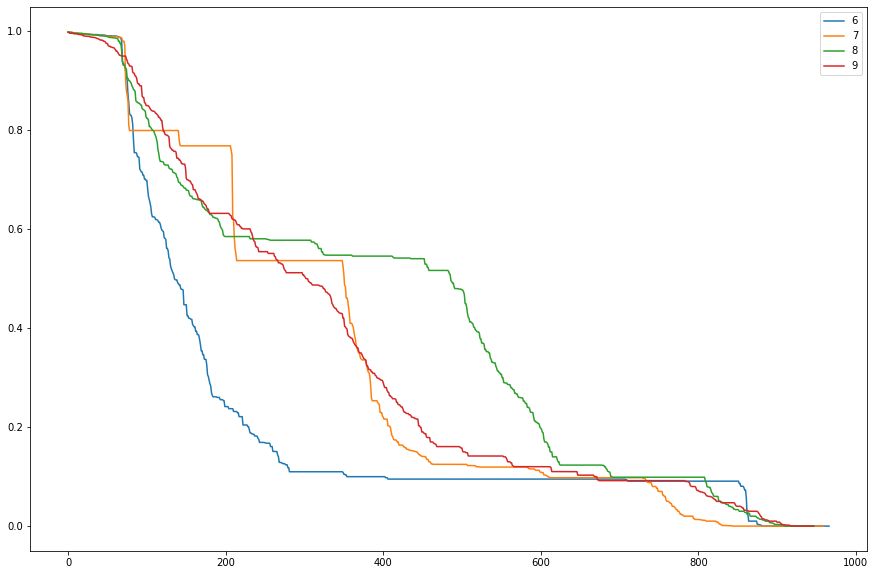

In [23]:
fig, ax = plt.subplots(figsize = (15,10))

for i in prefix_normal_loss.keys():
    ax.plot(prefix_normal_loss[i], label=i)

ax.legend()
plt.show()

In [19]:
roc_auc_score(gt_anomaly_test, normal_loss_dist)

1.0

In [26]:
1-adaptive_thr

0.99